In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


1. (5 points) Step 1: Data collection - Data is already given by the Competition

In [2]:
import random
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

Set global seed but the operation seed is not set here, we get different results for every call to the random op, but the same sequence for every re-run of the program.

In [3]:
tf.random.set_seed(1234)

For Memory Optimizaton and Utilization.

In [4]:
def downcastMemoryUsage(dataFrame):
    startMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is: {:.2f} MB'.format(startMemoryOptimization))
    subTypeInt = ['uint8','uint16','uint32','uint64','int8','int16','int32','int64']
    subTypeFloat = ['float16','float32','float64']
    for column in dataFrame.columns:
        columnType = str(dataFrame[column].dtypes)
        maximumColumn = dataFrame[column].max()
        minimumColumn = dataFrame[column].min()
        if 'int' in columnType:
            for element in subTypeInt:
                if minimumColumn > np.iinfo(element).min and maximumColumn < np.iinfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'float' in columnType:
            for element in subTypeFloat:
                if minimumColumn > np.finfo(element).min and maximumColumn < np.finfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'object' in columnType:
            if column =='date':
                dataFrame['date'] = pd.to_datetime(dataFrame['date'],format='%Y-%m-%d')
            else:
                numberOfUnique = len(dataFrame[column].unique())
                numberOfTotal = len(dataFrame[column])
                if numberOfUnique / numberOfTotal < 0.5:
                    dataFrame[column] = dataFrame[column].astype('category')
    endMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(endMemoryOptimization))
    print('Compressed by: {:.2f} %'.format(100*(startMemoryOptimization - endMemoryOptimization) / startMemoryOptimization))
    
    return dataFrame

A. Loading data into python

In [5]:
asset_df = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
downcastMemoryUsage(asset_df)

Memory usage of dataframe is: 0.00 MB
Memory usage after optimization is: 0.00 MB
Compressed by: 39.22 %


,Asset_ID,Weight,Asset_Name
0,2,2.398438,Bitcoin Cash
1,0,4.304688,Binance Coin
2,1,6.781250,Bitcoin
3,5,1.386719,EOS.IO
4,7,2.080078,Ethereum Classic
5,6,5.894531,Ethereum
6,9,2.398438,Litecoin
7,11,1.609375,Monero
8,13,1.791992,TRON
9,12,2.080078,Stellar


In [6]:
train_df = pd.read_csv('../input/g-research-crypto-forecasting/train.csv',nrows=5000) #start with the first 5K rows
train_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
4995,1514803800,11,2.0,337.9000,337.9100,337.9000,337.9000,4.000000,337.909000,0.002879
4996,1514803860,2,29.0,2383.7450,2387.9900,2379.1000,2383.5400,3.319748,2383.529794,-0.012628
4997,1514803860,0,14.0,8.3800,8.3800,8.3651,8.3660,399.390000,8.365515,-0.013866
4998,1514803860,1,135.0,13600.1140,13831.9000,13515.1400,13599.6540,16.184203,13597.192180,-0.014673


B. Report the number of data samples, the number of features.

In [7]:
len(train_df)

5000

In [8]:
len(asset_df)

14

Number of Features = 9

Number of rows = 5000

Number of columns =10


Calculate Percentage Weight for Each Coin.

In [9]:
asset_df.sort_values(by=['Weight'],ascending=False,inplace=True)
# df[percent] = (df['column_name'] / df['column_name'].sum()) * 100
asset_df['coinWeightPercent'] = (asset_df['Weight'] / asset_df['Weight'].sum()) * 100
asset_df

,Asset_ID,Weight,Asset_Name,coinWeightPercent
2,1,6.781250,Bitcoin,16.593750
5,6,5.894531,Ethereum,14.414062
10,3,4.406250,Cardano,10.781250
1,0,4.304688,Binance Coin,10.531250
13,4,3.554688,Dogecoin,8.695312
0,2,2.398438,Bitcoin Cash,5.867188
6,9,2.398438,Litecoin,5.867188
4,7,2.080078,Ethereum Classic,5.089844
9,12,2.080078,Stellar,5.089844
8,13,1.791992,TRON,4.386719


Plotting the Amount of Weight Each Crypto, Received in the Metric.

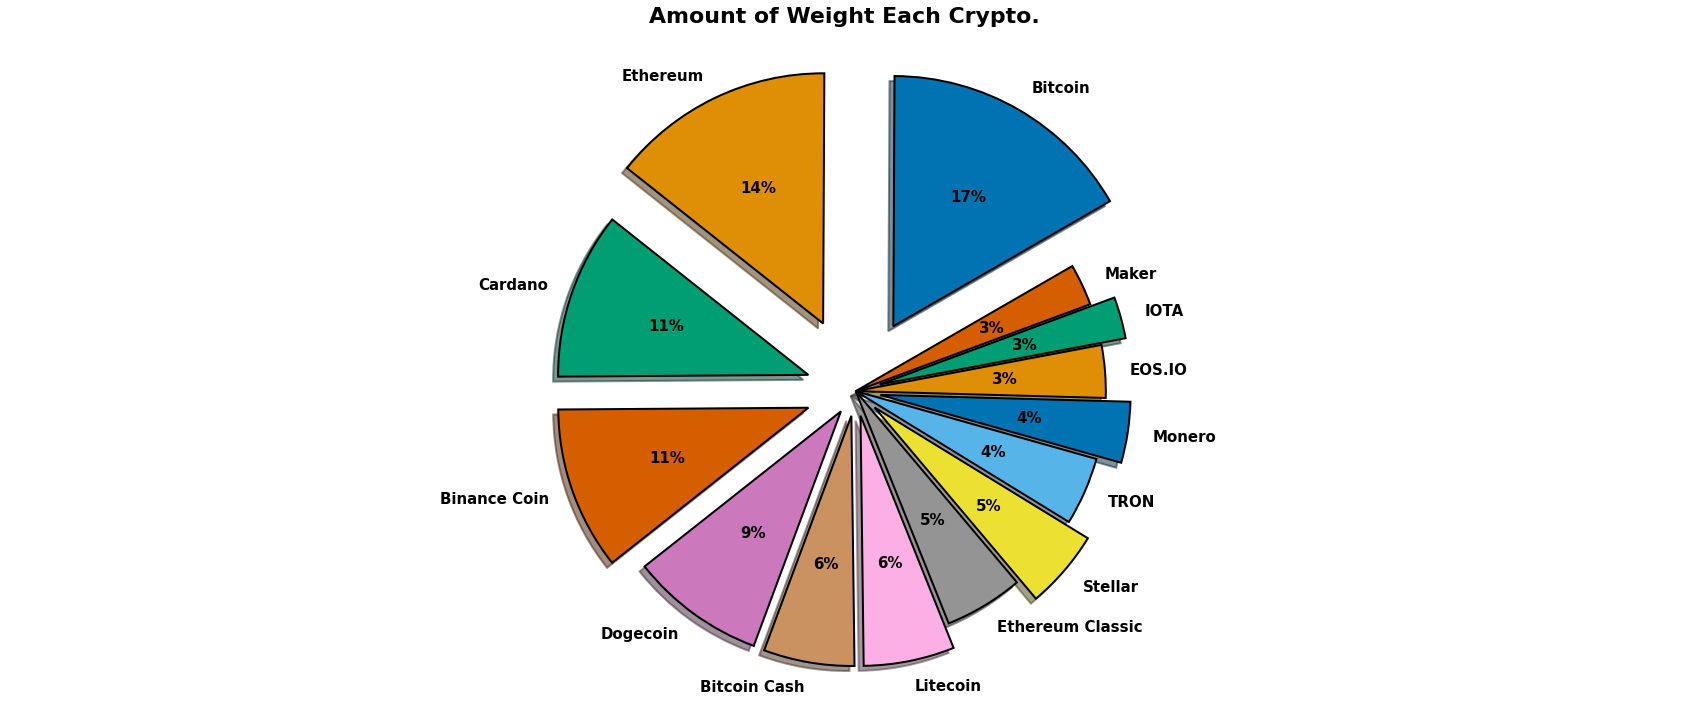

In [10]:
fig = plt.figure()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 5, box.height * 3])
colors = sns.color_palette('colorblind')[0:14]
labels = ['Bitcoin', 'Ethereum', 'Cardano', 'Binance Coin', 'Dogecoin', 'Bitcoin Cash', 'Litecoin', 'Ethereum Classic',
          'Stellar', 'TRON', 'Monero', 'EOS.IO', 'IOTA', 'Maker']
explode = (0.3, 0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0)
plt.pie(asset_df['coinWeightPercent'], colors=colors, autopct='%.0f%%', labels=labels, explode=explode,
        startangle=30, shadow=True, textprops={'fontweight': 'semibold', 'fontsize': 15},
        wedgeprops={'linewidth': 2, 'edgecolor': 'k'}, labeldistance=1.1)
plt.title("Amount of Weight Each Crypto.", fontweight="bold", fontsize=22, pad=21)
plt.axis('equal')
plt.show()

Convert "timestamp" to DateTime[s]

In [11]:
train_df['DateAndTime'] = pd.to_datetime(train_df['timestamp'], unit='s',utc = True,infer_datetime_format = True,).apply(lambda x:x.tz_convert('Europe/London'))
train_df['Date'] = train_df.DateAndTime.dt.date
train_df['Date'] = train_df['Date'].astype('datetime64[ns]')
train_df.set_index(['DateAndTime'], inplace=True)
downcastMemoryUsage(train_df)

Memory usage of dataframe is: 0.46 MB
Memory usage after optimization is: 0.18 MB
Compressed by: 61.46 %


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Date
DateAndTime,,,,,,,,,,,
2018-01-01 00:01:00+00:00,1514764860,2,40.0,2376.000000,2400.000000,2358.000000,2374.000000,19.234375,2374.000000,-0.004219,2018-01-01
2018-01-01 00:01:00+00:00,1514764860,0,5.0,8.531250,8.531250,8.531250,8.531250,78.375000,8.531250,-0.014397,2018-01-01
2018-01-01 00:01:00+00:00,1514764860,1,229.0,13832.000000,14016.000000,13664.000000,13848.000000,31.546875,13824.000000,-0.014641,2018-01-01
2018-01-01 00:01:00+00:00,1514764860,5,32.0,7.660156,7.660156,7.656250,7.656250,6628.000000,7.656250,-0.013924,2018-01-01
2018-01-01 00:01:00+00:00,1514764860,7,5.0,25.921875,25.921875,25.875000,25.875000,121.062500,25.890625,-0.008263,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 10:50:00+00:00,1514803800,11,2.0,338.000000,338.000000,338.000000,338.000000,4.000000,338.000000,0.002878,2018-01-01
2018-01-01 10:51:00+00:00,1514803860,2,29.0,2384.000000,2388.000000,2380.000000,2384.000000,3.320312,2384.000000,-0.012627,2018-01-01
2018-01-01 10:51:00+00:00,1514803860,0,14.0,8.382812,8.382812,8.367188,8.367188,399.500000,8.367188,-0.013863,2018-01-01


In [12]:
train_df.isnull().sum()

timestamp      0
Asset_ID       0
Count          0
Open           0
High           0
Low            0
Close          0
Volume         0
VWAP           0
Target       311
Date           0
dtype: int64

Handling the Null Values

In [13]:
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)


replace_missing(train_df['VWAP'])
replace_missing(train_df['Target'])

train_df.isnull().sum()

timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
Date         0
dtype: int64

Data Preprocessing

In [14]:
startDate = '2021-01-01'
endDate = '2021-12-31'
mask = (train_df['Date'] > startDate) & (train_df['Date'] <= endDate) & (train_df['Asset_ID'] == 1)
train_data1 = train_df.loc[mask]
train_data1

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Date
DateAndTime,,,,,,,,,,,


In [15]:
data_training = train_data1[train_data1['Date'] >= '2021-01-01'].copy()

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_df, test_size=0.5, random_state=42)
print(train_set.shape)
print(test_set.shape)

(2500, 11)
(2500, 11)


In [17]:
Test_set,val_set=train_test_split(test_set, test_size=0.5, random_state=42)
print(test_set.shape)
print(val_set.shape)

(2500, 11)
(1250, 11)


Plotting the dataset

Dimension of train data:  (2500, 11)
Dimension of test data:  (2500, 11)


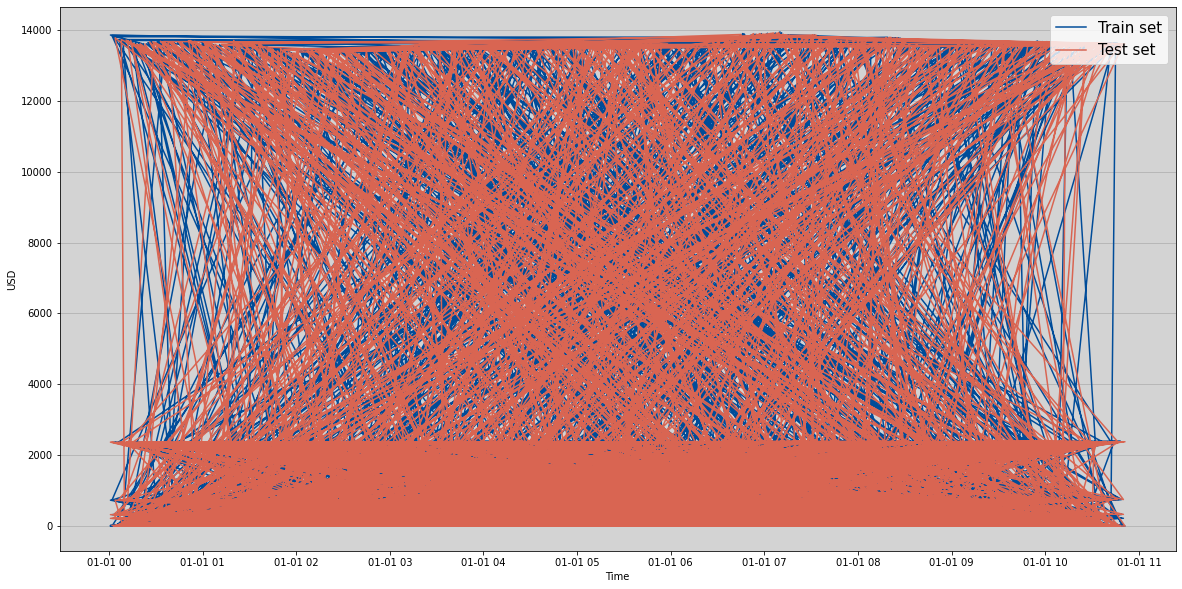

In [18]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(train_set.Close,color="#004C99")
ax.plot(test_set.Close,color="#D96552")
ax.set_facecolor("#D3D3D3")
plt.grid(b=True,axis = 'y')
ax.grid(b=True,axis = 'y')
plt.ylabel('USD')
plt.xlabel('Time')
plt.legend(['Train set', 'Test set'], loc='upper right',prop={'size': 15})
print('Dimension of train data: ',train_set.shape)
print('Dimension of test data: ', test_set.shape)

Splitting into training and testing set

In [19]:
# Split train data to X and y
X_train = train_set.drop(['timestamp','Asset_ID','Count','VWAP','Target','Date'], axis = 1)
y_train = train_set.loc[:,['Close']]

# Split test data to X and y
X_test = test_set.drop(['timestamp','Asset_ID','Count','VWAP','Target','Date'], axis = 1)
y_test = test_set.loc[:,['Close']]

The size of the training and testing set

In [20]:
print("X_train Dimensions:", X_train.shape)
print("y_train Dimensions:", y_train.shape)
print("X_test Dimensions:", X_test.shape)
print("y_test Dimensions:", y_test.shape)

X_train Dimensions: (2500, 5)
y_train Dimensions: (2500, 1)
X_test Dimensions: (2500, 5)
y_test Dimensions: (2500, 1)


Normalization

In [21]:
# MinMaxScaler is used to normalize the data
scaler = MinMaxScaler()

# Apply the scaler to training data
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

# Apply the scaler to test data
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

Create a 3D input dataset for Sk-Learn

In [22]:
# Create a 3D input for Scikit-Learn
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 30
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS)
X_train, y_train = create_dataset(X_train, y_train,TIME_STEPS)

print("X_train Dimensions:", X_train.shape)
print("y_train Dimensions:", y_train.shape)
print("X_test Dimensions:", X_test.shape)
print("y_test Dimensions:", y_test.shape)

X_train Dimensions: (2470, 30, 5)
y_train Dimensions: (2470, 1)
X_test Dimensions: (2470, 30, 5)
y_test Dimensions: (2470, 1)


Creating a LSTM Model 

In [23]:
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


Building a LSTM Model

In [24]:
model_lstm = create_model(32, LSTM)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Fitting the Model

In [25]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 150,  
                        validation_split = 0.1, batch_size = 1024, 
                        shuffle = False, callbacks = [early_stop])
    return history

In [26]:
history_lstm = fit_model(model_lstm)

2021-12-09 06:10:18.277515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
3/3 [==============================] - 6s 592ms/step - loss: 0.1465 - val_loss: 0.1430
Epoch 2/150
3/3 [==============================] - 0s 130ms/step - loss: 0.1321 - val_loss: 0.1421
Epoch 3/150
3/3 [==============================] - 0s 129ms/step - loss: 0.1326 - val_loss: 0.1395
Epoch 4/150
3/3 [==============================] - 0s 172ms/step - loss: 0.1296 - val_loss: 0.1403
Epoch 5/150
3/3 [==============================] - 0s 131ms/step - loss: 0.1283 - val_loss: 0.1416
Epoch 6/150
3/3 [==============================] - 0s 129ms/step - loss: 0.1284 - val_loss: 0.1403
Epoch 7/150
3/3 [==============================] - 0s 131ms/step - loss: 0.1270 - val_loss: 0.1384
Epoch 8/150
3/3 [==============================] - 0s 145ms/step - loss: 0.1265 - val_loss: 0.1374
Epoch 9/150
3/3 [==============================] - 0s 137ms/step - loss: 0.1257 - val_loss: 0.1370
Epoch 10/150
3/3 [==============================] - 0s 131ms/step - loss: 0.1262 - val_loss: 0.1371
Epoch 11/

In [27]:
# Plot train loss and validation loss
def plot_loss (history):
    fig, ax = plt.subplots(figsize = (20,10))
    ax.plot(history.history['loss'],color="#004C99")
    ax.plot(history.history['val_loss'],color="#D96552")
    ax.set_facecolor("#D3D3D3")
    plt.grid(b=True,axis = 'y')
    ax.grid(b=True,axis = 'y')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',prop={'size': 15})

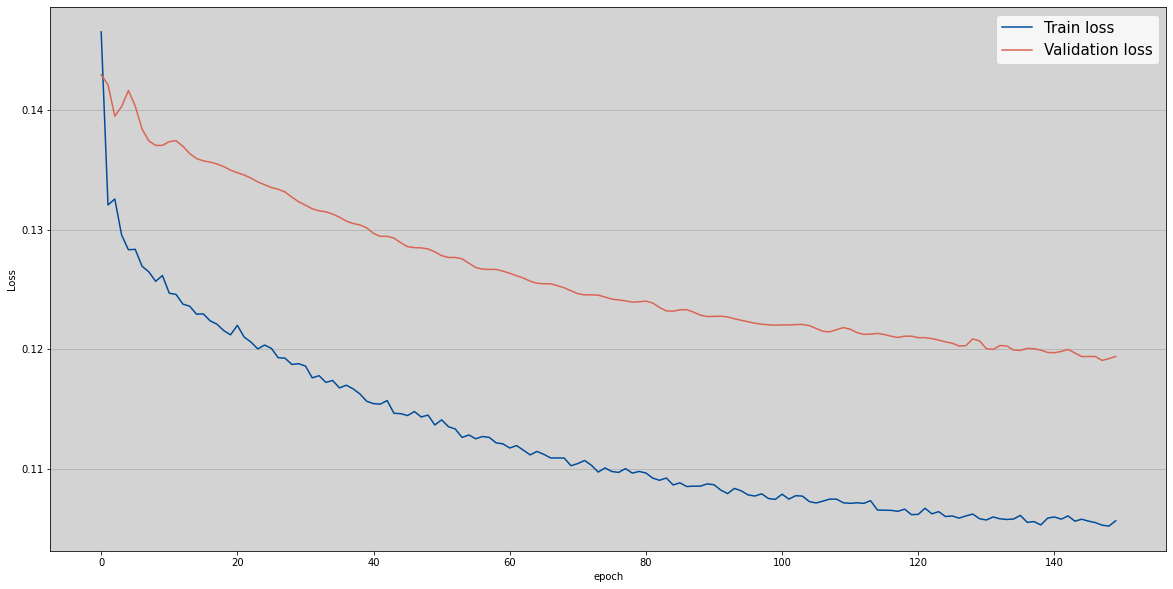

In [28]:
plot_loss (history_lstm)

In [29]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [30]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)

In [31]:
def plot_future(prediction, y_test):
    fig, ax = plt.subplots(figsize = (20,10))
    range_future = len(prediction)
    ax.plot(np.arange(range_future), np.array(y_test),label='Actual',color="#004C99")
    ax.plot(np.arange(range_future),np.array(prediction),label='Prediction',color="#D96552")
    ax.set_facecolor("#D3D3D3")
    plt.grid(b=True,axis = 'y')
    ax.grid(b=True,axis = 'y')
    plt.ylabel('USD')
    plt.legend(loc='upper left',prop={'size': 15})
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)    

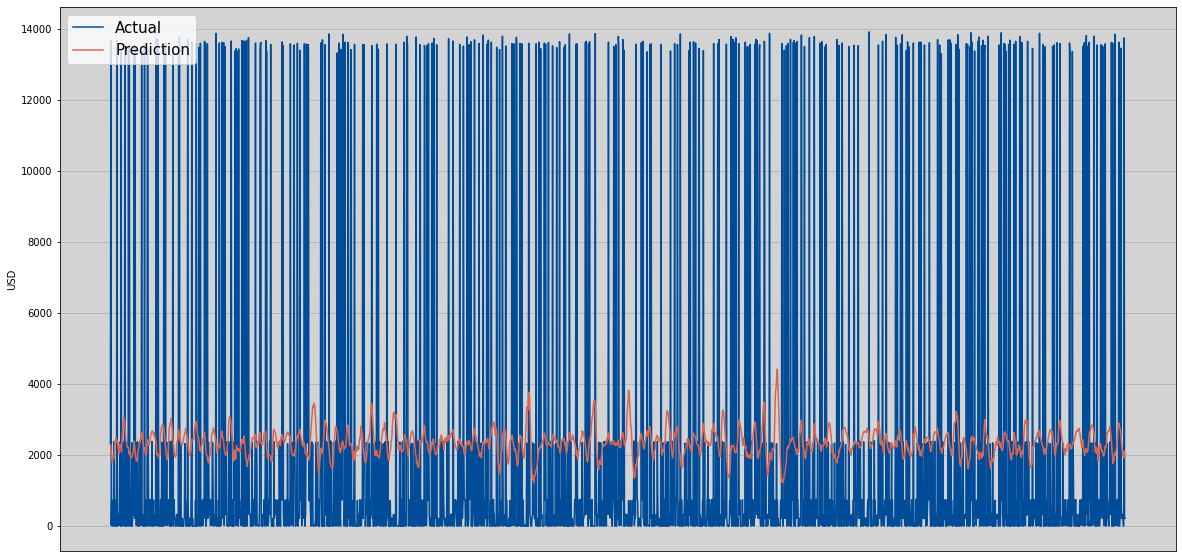

In [32]:
plot_future(prediction_lstm, y_test)